# Build US BLM Renewable suitablity layers for GRIDCERF


The following code was used to build the US BLM Renewable suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


### BLM Data Relevant to Multiple Technologies

According to a recent document from BLM (https://www.blm.gov/sites/default/files/documents/files/media-center-public-room-california-desert-renewable-energy-conservation-plan-overview.pdf): "4.2 million acres of public lands managed by the BLM are designated as National Conservation Lands, Areas of Critical Environmental Concern, wildlife allocations, and National Scenic and Historic Trail management corridors to conserve biological, cultural and other values. These lands are in addition to the 5 million acres of existing conservation in the desert. Lands within these designations are closed to renewable energy, and the BLM will not accept applications in these areas." National scenic and historic trails are already included in the GRIDCERF database under the common layers for all technologies. The following layers are compiled in this section:

    - Areas of Critical Environmental Concern (ACEC)
    - The California Desert Conservation Areas closed for leasing
    - National Landmarks and Research Natural Areas
    - Lands within BLM’s National Landscape Conservation System (e.g., National Historic and Scenic Trails)
    - Wildlife allocations

Data information:

- **Title**: BLM Natl Designated Areas of Critical Environmental Concern Polygons
- **Description from Source**: This polygon feature class shows the spatial extent and boundaries of Areas of Critical Environmental Concern that have become officially designated by the BLM. In general, the ACEC dataset defines areas within the public lands where special management attention is required to protect and prevent irreparable damage to important historic, cultural, or scenic values, fish and wildlife resources or other natural systems or processes, or to protect life and safety from natural hazards.

This polygon feature class shows the spatial extent and boundaries of Areas of Critical Environmental Concern that have become officially designated by the BLM. These polygon features were previously in a pre-designated status (i.e. being considered as areas to be eventually designated as official ACEC designated polygons). Once these polygon feature left the Pre-Designated phase (transitioned from a Considered to Designated status), they were removed from the ACEC Pre-designated polygon feature class and placed in this ACEC Designated polygon feature class. This dataset is a subset of the official national dataset, containing features and attributes intended for public release and has been optimized for online map service performance. The Implementation Guide represents the official national dataset from which this dataset was derived.
- **Source URL**:  https://gbp-blm-egis.hub.arcgis.com/datasets/blm-natl-designated-areas-of-critical-environmental-concern-polygons/about
- **Date Accessed**:  09/26/23
- **Citation**
> US Bureau of Land Management, 2023. BLM Natl Designated Areas of Critical Environmental Concern Polygons West-Wide Wind Mapping Project Maps and Data, https://www.arcgis.com/sharing/rest/content/items/11c9e34831c7446a8202b334bc64898a/data

____

- **Title**:  West Wide Wind Mapping Project: Cultural Resources
- **Description from Source**: - **Description from Source**: The following downloads include key layers used in the West-Wide Wind Mapping Project in Esri shapefile format, which can be used in Esri ArcGIS as well as many open-source GIS applications. These files contain the same data supplied in the WWMP Data Viewer, but grouped for easier downloading.
- **Source URL**:  https://wwmp.anl.gov/maps-data/
- **Date Accessed**:  09/26/23
- **Citation**
> Argonne National Laboratory, 2016. Cultural Resources. West-Wide Wind Mapping Project Maps and Data, https://wwmp.anl.gov/downloads/gis/Individual_Cultural_Resources.zip

____

- **Title**:  West Wide Wind Mapping Project: Ecological Resources
- **Description from Source**: - **Description from Source**: The following downloads include key layers used in the West-Wide Wind Mapping Project in Esri shapefile format, which can be used in Esri ArcGIS as well as many open-source GIS applications. These files contain the same data supplied in the WWMP Data Viewer, but grouped for easier downloading.
- **Source URL**:  https://wwmp.anl.gov/maps-data/
- **Date Accessed**:  09/26/23
- **Citation**
> Argonne National Laboratory, 2016. Ecological Resources. West-Wide Wind Mapping Project Maps and Data, https://wwmp.anl.gov/downloads/gis/Individual_Ecological_Resources.zip


### 1.3 Import modules


In [40]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features
from rasterio.plot import show

## 2. Configuration


In [7]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'blm_renewable_exclusions')

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF technology_specific data directory
common_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template siting mask raster
siting_mask_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# individual resource files applicable to multiple technologies
geothermal_source_dir = os.path.join(source_dir, 'geothermal_exclusions')
acec_file = os.path.join(geothermal_source_dir, "areas_of_critical_environmental_concern", "ACEC Designated Polygons.shp")

historic_dir = os.path.join(geothermal_source_dir, 'Individual_Cultural_Resources', 'Individual_Cultural_Resources')
landmark_shp = os.path.join(historic_dir, 'national_historic_landmark.shp')
park_shp = os.path.join(historic_dir, 'national_historic_park.shp') # polygon
register_shp = os.path.join(historic_dir, 'national_register_property.shp') # point

wild_alloc_file = os.path.join(geothermal_source_dir, "Individual_Ecological_Resources", 'Individual_Ecological_Resources',
                               "drecp_wildlife_allocation.shp")


output_acec_file = os.path.join(common_dir, 'gridcerf_blm_areas_of_critical_environmental_concern.tif')
output_wildlife_allocation_file = os.path.join(common_dir, 'gridcerf_blm_drecp_wildlife_allocation.tif')
output_historic_parks_file = os.path.join(common_dir, 'gridcerf_blm_historic_parks.tif')
output_historic_landmarks_file = os.path.join(common_dir, 'gridcerf_blm_historic_landmarks.tif')
output_nat_reg_file = os.path.join(common_dir, 'gridcerf_blm_national_register_property.tif')

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


In [23]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [29]:
def process_shp_file(source_file, crs):
    """ 
    Process shapefile and prepare  a rasterization field.
    """
    gdf = gpd.read_file(source_file).to_crs(crs)
    
    # set value
    gdf['value'] = 1

    return gdf

def compile_shps(dir_path, file_list, crs):
    
    for file in file_list:
        filename = file + '.shp'
        file_path = os.path.join(dir_path, filename)
        
        if file_list.index(file) == 0:
            state_gdf = process_shp_file(source_file=file_path, crs=crs)
        else:
            gdf = process_shp_file(source_file=file_path, crs=crs)
            state_gdf = pd.concat([state_gdf, gdf])
    
    return state_gdf

In [31]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

### 4.4 Individual Suitability Files

##### 4.4.1. US BLM Historic Landmarks

<Axes: >

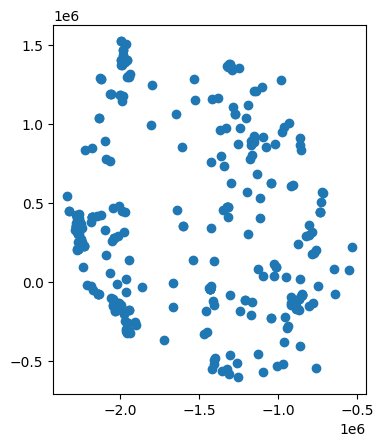

In [32]:
# process individual historic shapefiles
landmark_gdf = process_shp_file(landmark_shp, crs=crs)
landmark_gdf = gpd.clip(landmark_gdf, bdf)
landmark_gdf.plot()

In [33]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=siting_mask_raster,
                 gdf=landmark_gdf, 
                 value_field="value",
                 output_raster=output_historic_landmarks_file)

##### 4.4.2. US BLM Historic Parks

<Axes: >

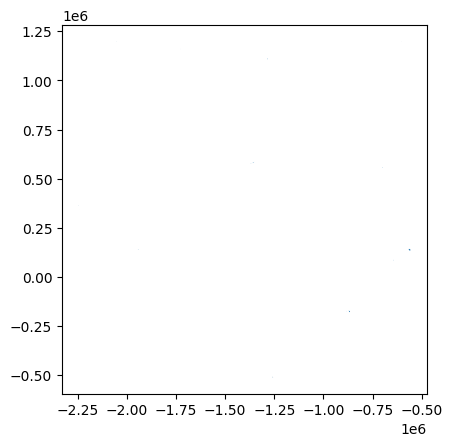

In [15]:
park_gdf = process_shp_file(park_shp, crs=crs)
# only keep areas within our GRIDCERF boundary
park_gdf = gpd.clip(park_gdf, bdf)
park_gdf.plot()

In [16]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=siting_mask_raster,
                 gdf=park_gdf, 
                 value_field="value",
                 output_raster=output_historic_parks_file)

##### 4.4.3. US BLM Historic Register

<Axes: >

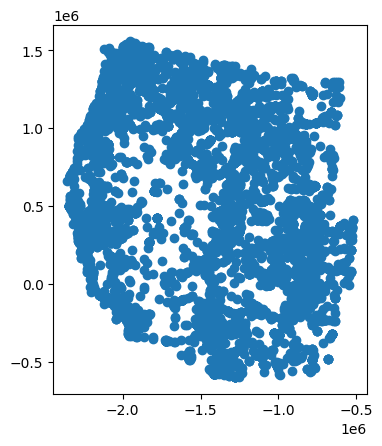

In [17]:
register_gdf = process_shp_file(register_shp, crs=crs)
register_gdf = gpd.clip(register_gdf, bdf)
register_gdf.plot()

In [18]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=siting_mask_raster,
                 gdf=register_gdf, 
                 value_field="value",
                 output_raster=output_nat_reg_file)

##### 4.4.4 US BLM Areas of Critical Environmental Concern

<Axes: >

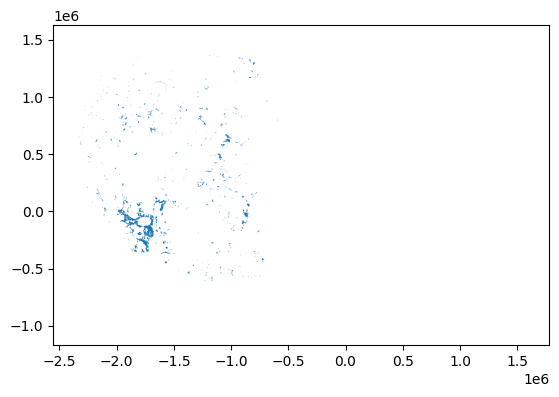

In [19]:
# areas of critical environmental concern
acec_gdf = process_shp_file(acec_file, crs=crs)
acec_gdf = gpd.clip(acec_gdf, bdf)
acec_gdf.plot()

In [20]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=siting_mask_raster,
                 gdf=acec_gdf, 
                 value_field="value",
                 output_raster=output_acec_file)

##### 4.4.5 Desert Renewable Energy Conservation Plan Wildlife Allocations

<Axes: >

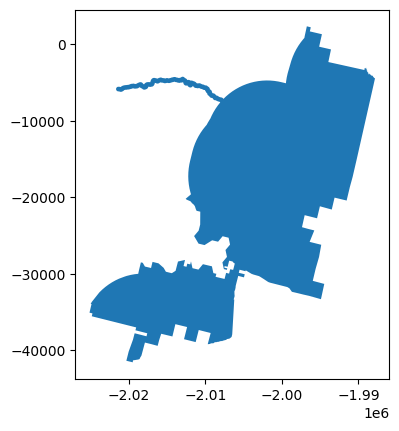

In [21]:
# wildlife allocation layer
wild_alloc_gdf = process_shp_file(wild_alloc_file, crs=crs)
wild_alloc_gdf = gpd.clip(wild_alloc_gdf, bdf)
wild_alloc_gdf.plot()

In [22]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=siting_mask_raster,
                 gdf=wild_alloc_gdf, 
                 value_field="value",
                 output_raster=output_wildlife_allocation_file)